# Report for Project 3 - Collaboration and Competition Udacity Deep Learning Nanodegree

*By: Fairoza Amira Binti Hamzah*

---

This notebook uses the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

This notebook is run in a PC with NVidia GTX 1050 Ti, 16GB RAM, i7-7700 CPU.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [0]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [0]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [0]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [0]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [0]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [0]:
#env.close()

### 4. The experiments

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Importing the necessary libraries to train the agent

Please refer to `agent.py` and `model.py` for the agent and model implementation in this notebook.

In [0]:
from collections import deque
import matplotlib.pyplot as plt
from agent import Agent
import torch
from replay_buffer import ReplayBuffer
import random

%matplotlib inline

#### Setting up the hyperparameters

**Model Training**

Multi Agent Deep Deterministic Policy Gradiets (DDPG) is used to train the agent. For more information in DDPG algorithm, refer to [this paper](https://arxiv.org/pdf/1509.02971.pdf) and [this paper](https://arxiv.org/pdf/1706.02275.pdf). The agent contains an actor and critic network. The same actor network is used for both agents to select actions. The experience is shared in the same replay buffer. 

Model architecture is tuned with various hidden layer units as shown in the experiment below.

In general, both actor and critic have 3 hidden layers with ReLU activation function. The output layer for actor is activated using tanh activation function.

In [0]:
BUFFER_SIZE=int(1e5)  # replay buffer size (1e6 in the original paper)
BATCH_SIZE=256   #minibatch size (64 in the original paper)
GAMMA=0.99     #discount factor
TAU=1e-2        #for soft update of target parameters
LR_ACTOR=1e-3     #learning rate of the actor
LR_CRITIC=1e-3   # learning rate of the critic   
WEIGHT_DECAY=0   #L2 weight decay (1e-2 in original paper)
RANDOM_SEED=0

agent1 = Agent(
    state_size=state_size,
    action_size=action_size,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

agent2 = Agent(
    state_size=state_size,
    action_size=action_size,
    memory=agent1.memory, # Sharing replay memory between ddpg agents. 
    batch_size=BATCH_SIZE,    
    gamma=GAMMA,           
    tau=TAU,
    lr_actor=LR_ACTOR,       
    lr_critic=LR_CRITIC,        
    weight_decay=WEIGHT_DECAY,
    random_seed=RANDOM_SEED
)

Episode 100	Average Score: 0.00 best_score 0.10000000149011612
Episode 200	Average Score: 0.00 best_score 0.10000000149011612
Episode 300	Average Score: 0.03 best_score 0.10000000149011612
Episode 400	Average Score: 0.30 best_score 2.20000003278255466
Episode 424	Average Score: 0.52 best_score 2.6000000387430196
Environment solved in 424 episodes!	Average Score: 0.52


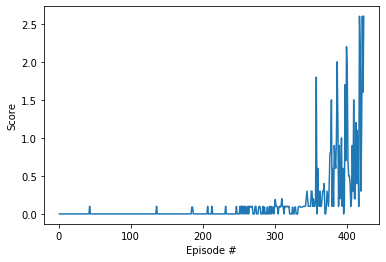

In [0]:
STOP_NOISE_AFTER_EP=300
env_info = env.reset(train_mode=True)[brain_name]
def ddpg(n_episodes=1500, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = 0.0
    add_noise = True
    for i_episode in range(1, n_episodes+1):
        if i_episode > STOP_NOISE_AFTER_EP:
            add_noise = False
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            action1 = agent1.act(states[0], add_noise=add_noise).tolist()
            action2 = agent2.act(states[1], add_noise=add_noise).tolist()
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        if max_score > best_score:
            best_score = max_score
        print('\rEpisode {}\tAverage Score: {:.2f} best_score {}'.format(i_episode, np.mean(scores_deque), best_score), end="")
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
            torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
            break
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [0]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action1 = agent1.act(states[0], add_noise=False).tolist()
        action2 = agent2.act(states[1], add_noise=False).tolist()
        actions = [action1, action2]
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 2.7000000402331352
Score (max over agents) from episode 5: 2.600000038743019


In [0]:
env.close()

**EXPERIMENT 1**

MODEL :<br/>
Actor- FC1 units (400), FC2 units (300) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
No dropout layer added <br/>
Optimizer: Adam

AGENT: <br/>
BUFFER_SIZE=int(1e6) <br/>
BATCH_SIZE=512 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 587 episodes with average score of 0.51.

<img src= "tennis_1.png">


**EXPERIMENT 2**

MODEL :<br/>
Actor- FC1 units (256), FC2 units (128) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
Dropout with probability 0.2 for each layer <br/>
Optimizer: Rectified Adam

AGENT: <br/>
BUFFER_SIZE=int(1e6) <br/>
BATCH_SIZE=256 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 450 episodes with average score of 0.5.

<img src= "tennis_2.png">

**EXPERIMENT 3**

MODEL :<br/>
Actor- FC1 units (400), FC2 units (300) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
No dropout layer added <br/>
Optimizer: Rectified Adam

AGENT: <br/>
BUFFER_SIZE=int(1e6) <br/>
BATCH_SIZE=512 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 546 episodes with average score of 0.51.

<img src= "tennis_3.png">

**EXPERIMENT 4**

MODEL :<br/>
Actor- FC1 units (256), FC2 units (128) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
Dropout for each layer with probability of 0.2 <br/>
Optimizer: Rectified Adam

AGENT: <br/>
BUFFER_SIZE=int(1e5) <br/>
BATCH_SIZE=256 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 596 episodes with average score of 0.51.

<img src= "tennis_4.png">

**EXPERIMENT 5**

MODEL :<br/>
Actor- FC1 units (400), FC2 units (300) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
Dropout for each layer with probability of 0.2 <br/>
Optimizer: Rectified Adam

AGENT: <br/>
BUFFER_SIZE=int(1e6) <br/>
BATCH_SIZE=512 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 587 episodes with average score of 0.50.

<img src= "tennis_5.png">

**EXPERIMENT 6**

MODEL :<br/>
Actor- FC1 units (256), FC2 units (128) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
Dropout for each layer with probability of 0.25 <br/>
Optimizer: Rectified Adam 

AGENT: <br/>
BUFFER_SIZE=int(1e5) <br/>
BATCH_SIZE=256 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 424 episodes with average score of 0.52.

<img src= "tennis_6.png">

**EXPERIMENT 6**

MODEL :<br/>
Actor- FC1 units (256), FC2 units (128) <br/>
Critic - FC1 units (256), FC2 units (128) <br/>
Dropout for each layer with probability of 0.25 <br/>
Optimizer: Adam 

AGENT: <br/>
BUFFER_SIZE=int(1e5) <br/>
BATCH_SIZE=256 <br/>    
TAU=1e-2 <br/>
LR_ACTOR=1e-3 <br/>    
LR_CRITIC=1e-3 <br/>      

RESULTS: <br/>
Environment solved in 536 episodes with average score of 0.50.

<img src= "tennis_7.png">

**Conclusion**

1. Models are built based on DDPG architecture. Both actor and critic networks have 3 fully connected layers. The networks architecture is changed with the amount of units in each layer, added the dropout for each layer. The first two layers in actor and critic used ReLU as activation function and the final layer used tanh.
2. Different hyperparameters are set to get the lowest episodes needed to solve the environment.
3. I have also tested the new optimizer, the Rectified Adam in this experiment, and the environment is solved in lower episodes compared to by using Adam.
4. Noise is added using an Ornstein-Uhlenbeck process (as recommended in the paper) where theta and sigma were set as 0.15 and 0.2, respectively.
5. Two agents share a replay buffer so that their experience is combined with training.

**Future Works**

Try to implement by using Proximal Policy Optimization (PPO) and Distributed Distributional Deterministic Policy Gradients (D4PG) instead of DDPG.
